Visualizing Missingness

/var/folders/mn/x1lsf_0j0dl4sxlkkmh0q5kr0000gn/T/ipykernel_5720/4246386362.py:6: DtypeWarning: Columns (10404) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')


Overall missingness in features: 99.10%
Number of features with any missingness: 10400 out of 10400


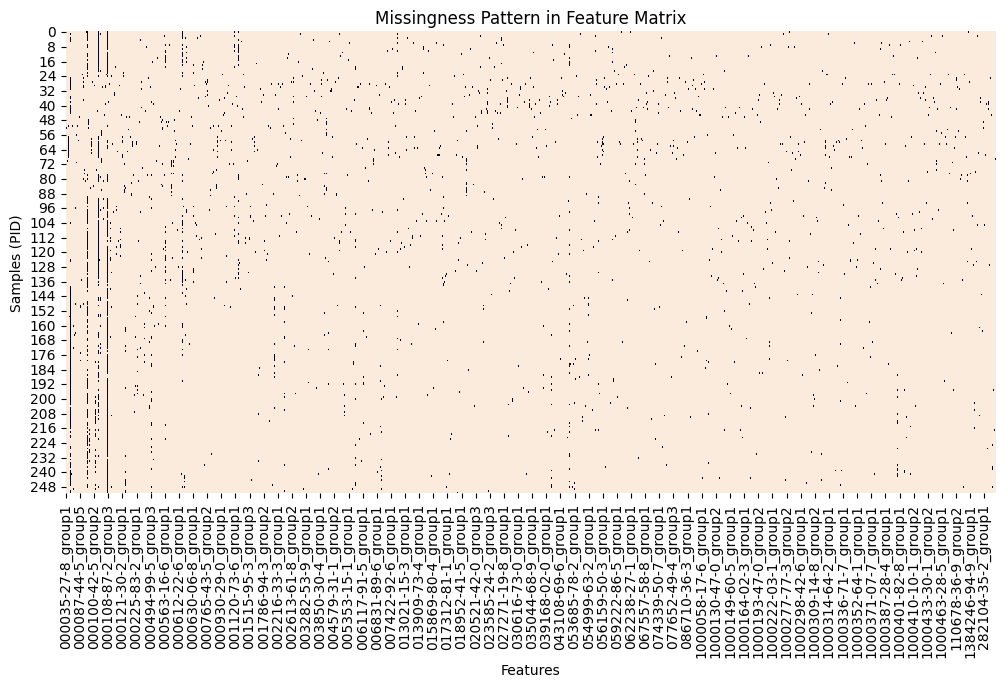

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading data
df_main2_cleaned = pd.read_csv('df_main2_cleaned.csv')

# Excluding demos
feature_cols = [col for col in df_main2_cleaned.columns if col not in ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']]
# dtype issue correction. It will still throw a warning, but the line below resolves this
df_main2_cleaned[feature_cols] = df_main2_cleaned[feature_cols].apply(pd.to_numeric, errors='coerce')


# How much is missing
missing_perc = df_main2_cleaned[feature_cols].isnull().mean().mean() * 100
print(f"Overall missingness in features: {missing_perc:.2f}%")

# How many features are missing
features_with_missing = df_main2_cleaned[feature_cols].isnull().any().sum()
print(f"Number of features with any missingness: {features_with_missing} out of {len(feature_cols)}")

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(df_main2_cleaned[feature_cols].isnull(), cbar=False)
plt.title('Missingness Pattern in Feature Matrix')
plt.xlabel('Features')
plt.ylabel('Samples (PID)')
plt.show()

In [7]:
# Filter to keep only features present >=10% of samples
min_present = len(df_main2_cleaned) * 0.10
filtered_features = [col for col in feature_cols if df_main2_cleaned[col].notnull().sum() >= min_present]
print(f"Features retained after filtering: {len(filtered_features)}")
df_main2_clean_filter = df_main2_cleaned[filtered_features]

Features retained after filtering: 82


This is a huge drop in features, but not suprising. Dropping from 10,400 to 82 seems reasonable as this is exhalled VOCs.

**NOTE:** Unable to use BaylorEdPsych package for Little's MCAR does not work with current versions of R and is a noted grevience in the community. The same goes for running QRILC with the imputeLCMD package. Packages for R 4.4 have not been udpated which is why they are not working. 

Pivoting now to MissForest which is a non-parametric imputation method that uses RF to estimate missing data.

**FIXME** There's a lot of papers on this, make sure to cite.

In [21]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()


# transfering into an R df
r_df = pandas2ri.py2rpy(df_main2_clean_filter)
# Load MissForest
ro.r('library(missForest)')
# transfer dataframe into R workspace
ro.globalenv['r_df'] = r_df
ro.r('set.seed(123)')  # setting seed for reproducibility


# Running imputation
ro.r('imputed_result <- missForest(r_df)')
# Extracting imputed data
ro.r('df_imputed <- imputed_result$ximp')


# Sending back to python
df_imputed = pandas2ri.rpy2py(ro.r('df_imputed'))
print("Imputed data shape:", df_imputed.shape)  # QC step

# Confirm df_main2_clean_filter is 252x82
print("df_main2_clean_filter shape:", df_main2_clean_filter.shape)  # QC step
# merging
demographics = df_main2_cleaned.loc[df_main2_clean_filter.index, ['PID', 'TB Status', 'Age', 'BMI', 'HIV Status']]
# Combine everything
df_main3 = pd.concat([demographics.reset_index(drop=True), pd.DataFrame(df_imputed, columns=df_main2_clean_filter.columns).reset_index(drop=True)], axis=1)

print("Final merged dataframe shape:", df_main3.shape)  # QC step
# df_main3.to_csv('df_main3.csv', index=False)  # if there's a need to save

Imputed data shape: (252, 82)
df_main2_clean_filter shape: (252, 82)
Final merged dataframe shape: (252, 87)


“Missing values were imputed using the MissForest algorithm (Stekhoven & Bühlmann, 2012) implemented in R (v4.4.0) via the missForest package. This non-parametric random forest-based method accommodates complex, non-linear relationships and is appropriate for left-censored MNAR data common in GCMS datasets.”

**NOTE TO SELF** we skipped TIC because they already should have been TIC'd before. 

Running df_main3.describe() confirms this

In [23]:
df_main3.describe()  # QC step to confirm TIC already occured

,Age,BMI,000067-64-1_group2,000067-68-5_group1,000074-95-3_group1,000074-97-5_group1,000077-68-9_group1,000078-79-5_group2,000078-93-3_group1,000086-73-7_group1,...,052195-40-1_group3,054446-78-5_group1,063521-76-6_group3,095798-15-5_group1,1000132-10-9_group2,1000308-17-8_group1,1000309-13-0_group1,1000386-40-2_group1,1000401-12-0_group1,1000417-00-6_group1
count,113.000000,113.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,...,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,36.336283,22.370555,0.524356,0.184274,0.074772,1.511498,0.180392,0.685153,0.114337,0.024919,...,0.223086,0.223509,0.178715,1.406376,0.065231,0.093712,0.514791,0.219269,0.108907,0.084422
std,11.799372,4.536496,0.162309,0.047014,0.019647,0.915038,0.091602,0.441136,0.060789,0.008983,...,0.152147,0.079393,0.045463,0.358838,0.013472,0.033500,0.135458,0.132642,0.037129,0.026969
min,18.000000,13.714286,0.068700,0.027700,0.017900,0.030600,0.037400,0.045800,0.016700,0.004200,...,0.037200,0.044200,0.035600,0.240000,0.025200,0.009900,0.133500,0.009500,0.019900,0.024900
25%,27.000000,19.531250,0.440931,0.158031,0.062424,0.907221,0.136119,0.374535,0.068432,0.017779,...,0.107736,0.184364,0.152322,1.204029,0.055534,0.071000,0.453148,0.104114,0.088289,0.063220
50%,33.000000,21.773842,0.517836,0.190450,0.077179,1.443497,0.154034,0.559534,0.103031,0.024809,...,0.184857,0.213595,0.184762,1.388175,0.064403,0.089162,0.493325,0.183480,0.104638,0.082631
75%,46.000000,24.464602,0.614665,0.224715,0.089925,2.032710,0.193950,0.900852,0.153751,0.029259,...,0.296523,0.259121,0.208735,1.577843,0.073912,0.117309,0.567547,0.306042,0.131094,0.095902
max,65.000000,38.514057,1.049000,0.351500,0.154200,6.480900,0.792200,2.956400,0.637400,0.080800,...,1.515500,0.790700,0.355700,3.918500,0.123300,0.262400,1.393500,0.907900,0.267300,0.213800


**Z-Scoring data**

Z-scored feature means (should be ~0):000067-64-1_group2     4.863834e-16
000067-68-5_group1    -1.409807e-17
000074-95-3_group1    -4.793344e-16
000074-97-5_group1     6.696583e-17
000077-68-9_group1    -1.268826e-16
                           ...     
1000308-17-8_group1   -2.775558e-16
1000309-13-0_group1    6.767074e-16
1000386-40-2_group1    1.057355e-16
1000401-12-0_group1    3.383537e-16
1000417-00-6_group1    1.127846e-16
Length: 82, dtype: float64 

Z-scored feature std devs (should be ~1): 000067-64-1_group2     1.00199
000067-68-5_group1     1.00199
000074-95-3_group1     1.00199
000074-97-5_group1     1.00199
000077-68-9_group1     1.00199
                        ...   
1000308-17-8_group1    1.00199
1000309-13-0_group1    1.00199
1000386-40-2_group1    1.00199
1000401-12-0_group1    1.00199
1000417-00-6_group1    1.00199
Length: 82, dtype: float64 



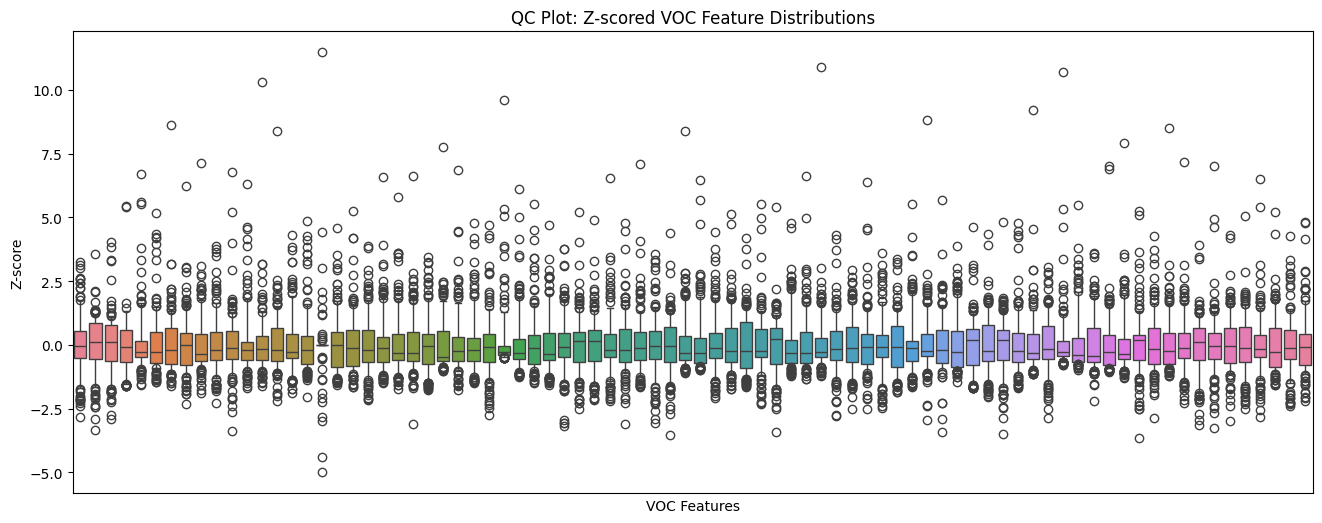

In [33]:
from sklearn.preprocessing import StandardScaler

# Extract VOC feature columns
feature_cols = df_main2_clean_filter.columns  # same 82 features

scaler = StandardScaler()
df_main3_z = df_main3.copy()
df_main3_z[feature_cols] = scaler.fit_transform(df_main3[feature_cols])

# QC
print(f"Z-scored feature means (should be ~0):{df_main3_z[feature_cols].mean()} \n")
print(f"Z-scored feature std devs (should be ~1): {df_main3_z[feature_cols].std()} \n")

# Boxplot
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_main3_z[feature_cols], whis=[5, 95])
plt.title('QC Plot: Z-scored VOC Feature Distributions')
plt.xlabel('VOC Features')
plt.ylabel('Z-score')
plt.xticks([], [])  # x-axis labels hidden for clarity bc so many features
plt.show()

# Saving
df_main3_z.to_csv('df_main_normalized.csv', index=False)

When looking at the above plot...
* no one feature stands out more than another
* Most are centered around 0
* IQR mostly between +/- 1
* Outliers are both above and below which seems to make sense given variability of breath based VOCs

**QC checks out, normalization worked**